# GAN - SUPER Resolution
4 gb 가량의 데이터셋 다운로드
```
>>> import tensroflow_datasets as tfds
>>> tfds.load("div2k/bicubic_x4")
>>> !pip install opencv-python
>>> !pip install scikit-image
```

(300, 451, 3)


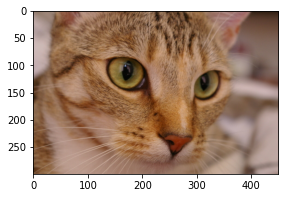

In [2]:
from skimage import data
import matplotlib.pyplot as plt

hr_image = data.chelsea()
hr_shape = hr_image.shape[:2]

print(hr_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

(100, 150, 3)


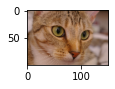

In [3]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(150, 100))

print(lr_image.shape)

plt.figure(figsize=(3,1))
plt.imshow(lr_image)

* Bilinear 와 Bicubic interpolation 결과물과 원본 비교
    - 세밀한 정보가 다 손실되어 원본과 크게 차이가 나는 것을 볼 수 있다.

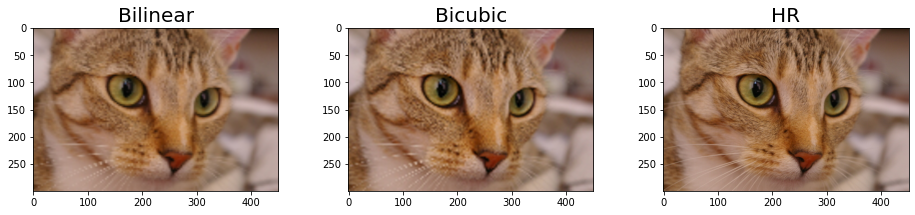

In [4]:
bilinear_image = cv2.resize(
    lr_image,
    dsize=(451, 300),
    interpolation=cv2.INTER_LINEAR   # bilinear interpolation
)

bicubic_image = cv2.resize(
    lr_image,
    dsize=(451, 300),
    interpolation=cv2.INTER_CUBIC   # bicubic interpolation
)

images = [bilinear_image, bicubic_image, hr_image]
titles = ['Bilinear', 'Bicubic', 'HR']

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

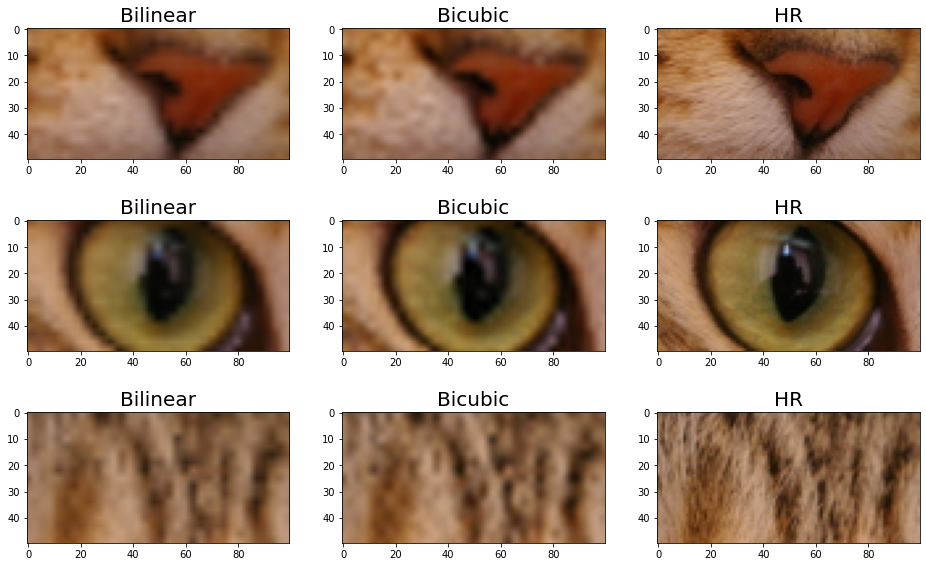

In [6]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(220,200)] *3 + [(90,120)] *3 + [(30,200)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

## SRCNN
'Image Super-Resolution Uisng Deep COnvolution Networks'. 2014

### 데이터 준비하기
`tensorflow-datasets` 라이브러리 `DIV2K : div2k/bicubic_x4`: 고해상도 이미지를 bicubic interpolation 으로 1/4배 픽셀을 줄인 데이터셋

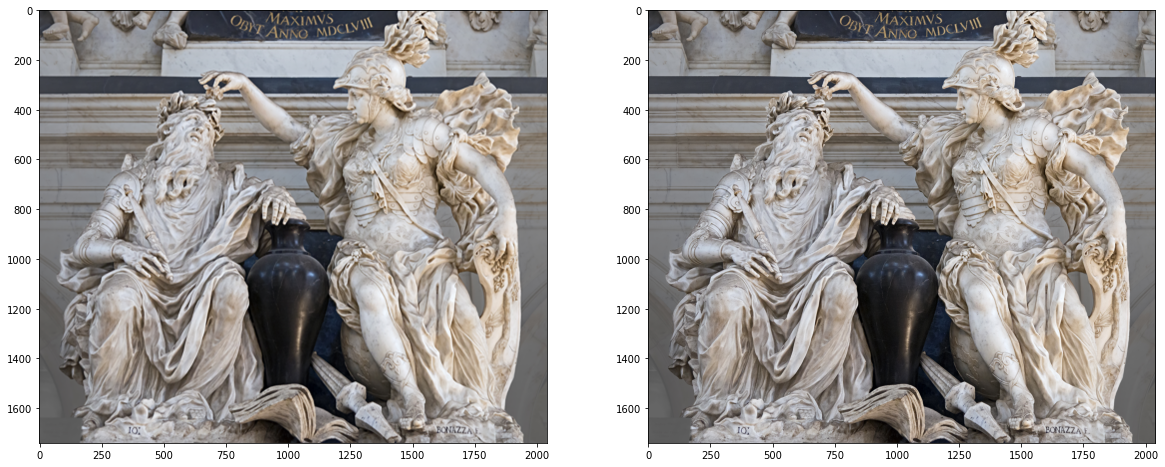

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

train, valid = tfds.load(
    "div2k/bicubic_x4",
    split=['train','validation'],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break
        
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
    lr,
    dsize=(hr.shape[1], hr.shape[0]),   # 고해상도 이미지크기
    interpolation=cv2.INTER_CUBIC   # bicubic 설정
)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr)
plt.subplot(1,2,2); plt.imshow(hr)

Text(0.5, 1.0, 'HR')

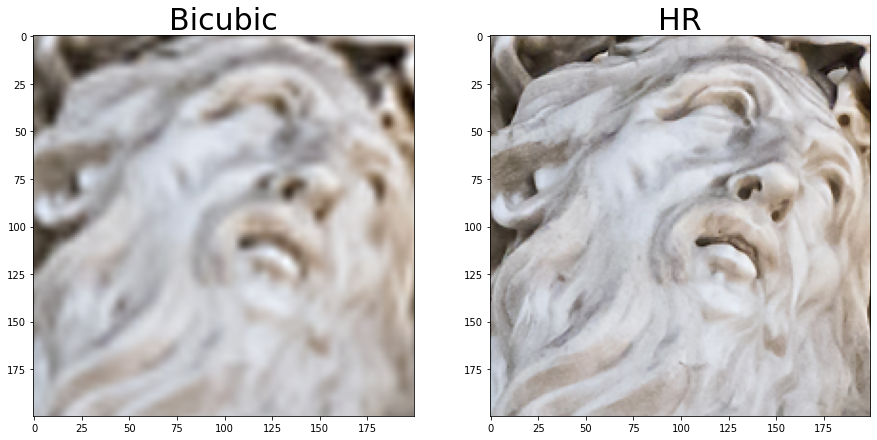

In [10]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (400, 500)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_hr = crop(hr, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title("HR", fontsize=30)

In [12]:
import tensorflow as tf

def preprocessing(lr, hr):
    hr = tf.image.random_crop(hr, size=[96,96,3])
    hr = tf.cast(hr, tf.float32) / 255.
    
    # 잘라낸 고해상도 이미지의 가로 세로 픽셀 수를 1/4배로 줄였다가
    # interpolatin 다시 원래크기로 돌립니다
    # 이렇게 만든 저해상도 이미지를 입력으로 사용합니다
    lr = tf.image.resize(hr, [96//4, 96//4], 'bicubic')
    lr = tf.image.resize(lr, [96, 96], 'bicubic')
    return lr, hr

train = train.map(preprocessing).shuffle(buffer_size=10).batch(16)
valid = valid.map(preprocessing).batch(16)

### SRCNN 구현하기

In [13]:
from tensorflow.keras import layers, Sequential

srcnn = Sequential()
# 9x9 크기의 필터를 128개 사용합니다
srcnn.add(layers.Conv2D(128, 9, padding='same', input_shape=(None,None,3)))
srcnn.add(layers.ReLU())
# 5x5 크기의 어터 64개 사용
srcnn.add(layers.Conv2D(64, 5, padding='same'))
srcnn.add(layers.ReLU())
# 5x5 크기의 어터 64개 사용
srcnn.add(layers.Conv2D(3, 5, padding='same'))

srcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   31232     
_________________________________________________________________
re_lu (ReLU)                 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     4803      
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


### 모델 학습하기

In [15]:
srcnn.compile(
    optimizer='adam',
    loss='mse'
)

srcnn.fit(train, validation_data=valid, epochs=1)   # 우선 epoch 1 만 학습

50/50 [==============================] - 59s 879ms/step - loss: 0.0516 - val_loss: 0.0082


### SRCNN 테스트하기
학습이 이미 완료된 모델을 불러와 테스트 실행\
`srcnn.h5` 3 MB 크기의 모델 로드

In [16]:
#!mkdir -p ~/aiffel/super_resolution

In [17]:
#!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/srcnn.h5

--2021-11-18 02:06:57--  https://aiffelstaticprd.blob.core.windows.net/media/documents/srcnn.h5
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2925960 (2.8M) [application/x-hdf]
Saving to: ‘srcnn.h5’

srcnn.h5            100%[===================>]   2.79M  1.15MB/s    in 2.4s    

2021-11-18 02:07:00 (1.15 MB/s) - ‘srcnn.h5’ saved [2925960/2925960]



In [18]:
#!mv srcnn.h5 ~/aiffel/super_resolution

In [22]:
import tensorflow as tf
import os

model_file = os.getenv("HOME")+'/aiffel/super_resolution/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

In [24]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr>1] = 1
    sr[sr<0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

srcnn_hr = apply_srcnn(bicubic_hr)

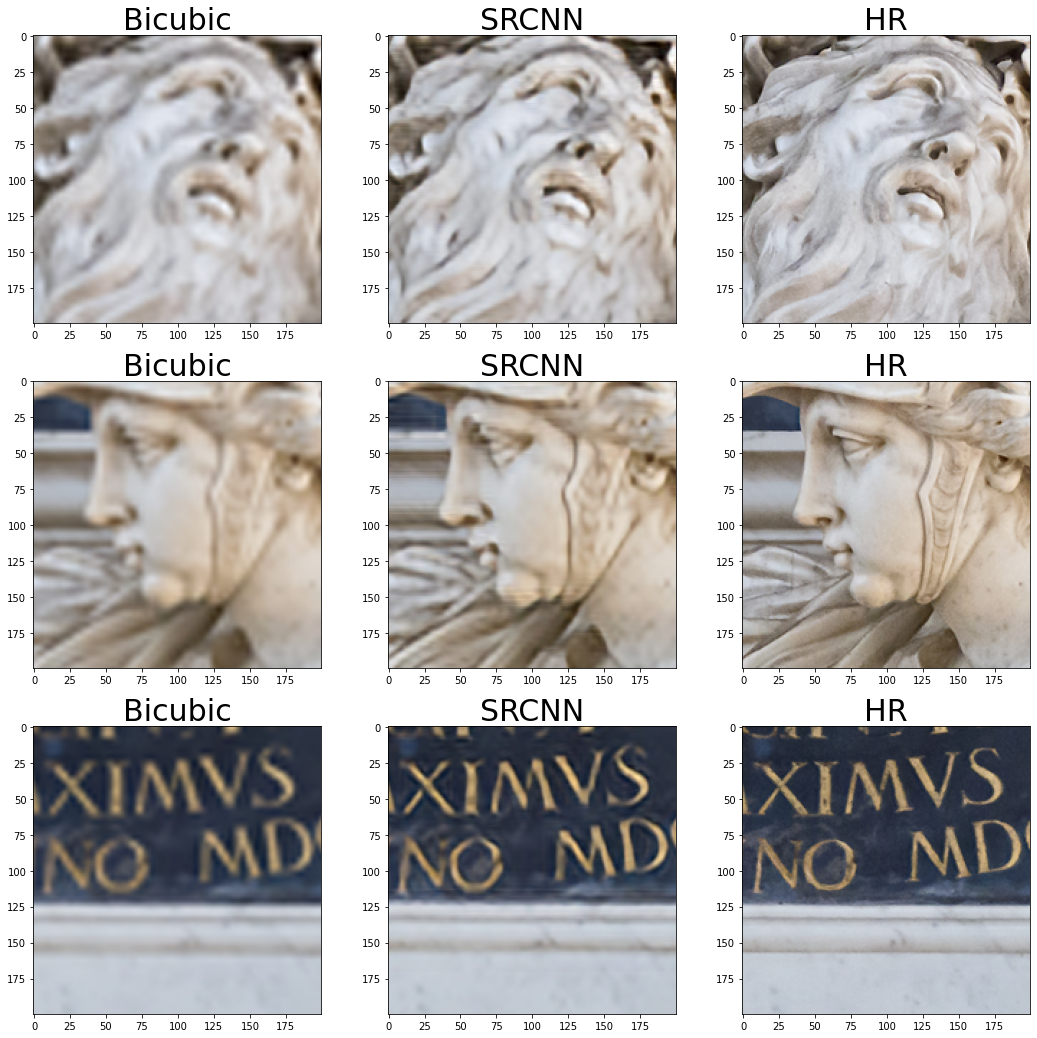

In [27]:
left_tops = [(400,500),(300,1200),(0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srcnn_hr, left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])
    
labels = ['Bicubic','SRCNN','HR'] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

SRCNN 으로 생성한 이미지의 디테일이 조금 더 채워진 것을 볼 수 있지만, 아직 고해상도에 비교했을때 부족한 결과물로 평가할 수 있다. 중간 정도의 해상도?

# SRGAN !
GAN Generative Adversarial Networks